# Mini Project - Time Series

## Business objective

### To build a forecast model to predict the furniture sales of a certain store

# Import libraries

In [194]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import LabelEncoder
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller,acf,pacf

from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.statespace.tools import diff

from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX



from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

In [299]:
df=pd.read_excel("Proj4_TimeSeries_Sales_Data_Project.xls",index_col='Order Date',parse_dates=True)
df

,Row ID,Order ID,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
Order Date,,,,,,,,,,,,,,,,,,,,
2016-11-08,1,CA-2016-152156,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
2016-11-08,2,CA-2016-152156,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2016-06-12,3,CA-2016-138688,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
2015-10-11,4,US-2015-108966,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
2015-10-11,5,US-2015-108966,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-01-21,9990,CA-2014-110422,2014-01-23,Second Class,TB-21400,Tom Boeckenhauer,Consumer,United States,Miami,Florida,33180,South,FUR-FU-10001889,Furniture,Furnishings,Ultra Door Pull Handle,25.2480,3,0.20,4.1028
2017-02-26,9991,CA-2017-121258,2017-03-03,Standard Class,DB-13060,Dave Brooks,Consumer,United States,Costa Mesa,California,92627,West,FUR-FU-10000747,Furniture,Furnishings,Tenex B1-RE Series Chair Mats for Low Pile Car...,91.9600,2,0.00,15.6332
2017-02-26,9992,CA-2017-121258,2017-03-03,Standard Class,DB-13060,Dave Brooks,Consumer,United States,Costa Mesa,California,92627,West,TEC-PH-10003645,Technology,Phones,Aastra 57i VoIP phone,258.5760,2,0.20,19.3932


In [302]:
df=df[df['Category']=='Furniture']

# Data understanding

In [303]:
df.columns

Index(['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID',
       'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code',
       'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name',
       'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='object')

In [304]:
df.size            #total number of observations

42420

In [305]:
df.shape        #rows and columns

(2121, 20)

In [306]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2121 entries, 2016-11-08 to 2017-02-26
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Row ID         2121 non-null   int64         
 1   Order ID       2121 non-null   object        
 2   Ship Date      2121 non-null   datetime64[ns]
 3   Ship Mode      2121 non-null   object        
 4   Customer ID    2121 non-null   object        
 5   Customer Name  2121 non-null   object        
 6   Segment        2121 non-null   object        
 7   Country        2121 non-null   object        
 8   City           2121 non-null   object        
 9   State          2121 non-null   object        
 10  Postal Code    2121 non-null   int64         
 11  Region         2121 non-null   object        
 12  Product ID     2121 non-null   object        
 13  Category       2121 non-null   object        
 14  Sub-Category   2121 non-null   object        
 15  Pro

In [307]:
df.describe().T        #summary of numerical data

,count,mean,std,min,25%,50%,75%,max
Row ID,2121.0,5041.643564,2885.740258,1.0000,2568.000,5145.0000,7534.0000,9991.000
Postal Code,2121.0,55726.556341,32261.888225,1040.0000,22801.000,60505.0000,90032.0000,99301.000
Sales,2121.0,349.834887,503.179145,1.8920,47.040,182.2200,435.1680,4416.174
Quantity,2121.0,3.785007,2.251620,1.0000,2.000,3.0000,5.0000,14.000
Discount,2121.0,0.173923,0.181547,0.0000,0.000,0.2000,0.3000,0.700
Profit,2121.0,8.699327,136.049246,-1862.3124,-12.849,7.7748,33.7266,1013.127


In [308]:
df.describe(include='object').T          #summary of object data

,count,unique,top,freq
Order ID,2121,1764,US-2015-129007,4
Ship Mode,2121,4,Standard Class,1248
Customer ID,2121,707,SV-20365,15
Customer Name,2121,707,Seth Vernon,15
Segment,2121,3,Consumer,1113
Country,2121,1,United States,2121
City,2121,371,New York City,192
State,2121,48,California,444
Region,2121,4,West,707
Product ID,2121,375,FUR-FU-10004270,16


In [309]:
data.isnull().sum()

Sales                      0
Quantity                   0
Discount                   0
Profit                     0
Ship Mode encode           0
Segment encode             0
City encode                0
State encode               0
Region encode              0
Category encode            0
Sub-Category encode        0
predicted_values           0
smooth_values              0
error                      0
predicted_values_SARIMA    0
dtype: int64

### There are no null values in the data

In [310]:
df.describe(include='object').T          #summary of object data

,count,unique,top,freq
Order ID,2121,1764,US-2015-129007,4
Ship Mode,2121,4,Standard Class,1248
Customer ID,2121,707,SV-20365,15
Customer Name,2121,707,Seth Vernon,15
Segment,2121,3,Consumer,1113
Country,2121,1,United States,2121
City,2121,371,New York City,192
State,2121,48,California,444
Region,2121,4,West,707
Product ID,2121,375,FUR-FU-10004270,16


## We drop few columns which do not effect the sales

In [311]:
a=df.drop(columns=['Order ID','Row ID','Customer ID','Customer Name','Country','Product ID','Postal Code','Product ID','Product Name','Ship Date'])

In [312]:
a

,Ship Mode,Segment,City,State,Region,Category,Sub-Category,Sales,Quantity,Discount,Profit
Order Date,,,,,,,,,,,
2016-11-08,Second Class,Consumer,Henderson,Kentucky,South,Furniture,Bookcases,261.9600,2,0.00,41.9136
2016-11-08,Second Class,Consumer,Henderson,Kentucky,South,Furniture,Chairs,731.9400,3,0.00,219.5820
2015-10-11,Standard Class,Consumer,Fort Lauderdale,Florida,South,Furniture,Tables,957.5775,5,0.45,-383.0310
2014-06-09,Standard Class,Consumer,Los Angeles,California,West,Furniture,Furnishings,48.8600,7,0.00,14.1694
2014-06-09,Standard Class,Consumer,Los Angeles,California,West,Furniture,Tables,1706.1840,9,0.20,85.3092
...,...,...,...,...,...,...,...,...,...,...,...
2015-03-19,First Class,Home Office,Houston,Texas,Central,Furniture,Bookcases,383.4656,4,0.32,-67.6704
2016-12-05,Second Class,Corporate,Newark,Delaware,East,Furniture,Furnishings,13.4000,1,0.00,6.4320
2015-09-06,Second Class,Consumer,Lafayette,Louisiana,South,Furniture,Tables,85.9800,1,0.00,22.3548


### There are few categorical columns, we need to encode them into numerical columns

# Label encoding

In [313]:
label=LabelEncoder()

In [314]:
a['Ship Mode encode']=label.fit_transform(a['Ship Mode'])

In [315]:
a['Segment encode']=label.fit_transform(a['Segment'])

In [316]:
a['City encode']=label.fit_transform(a['City'])

In [317]:
a['State encode']=label.fit_transform(a['State'])

In [318]:
a['Region encode']=label.fit_transform(a['Region'])

In [319]:
a['Category encode']=label.fit_transform(a['Category'])

In [320]:
a['Sub-Category encode']=label.fit_transform(a['Sub-Category'])

# EDA

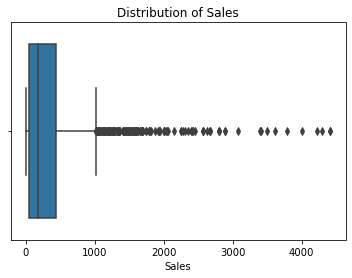

In [321]:
sns.boxplot(a['Sales'])
plt.title("Distribution of Sales")
plt.show()

### The range of sales lies between 0 to 500

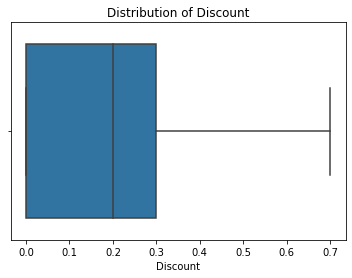

In [322]:
sns.boxplot(a['Discount'])
plt.title("Distribution of Discount")
plt.show()

### The discount ranges from 0 - 0.3 for furniture

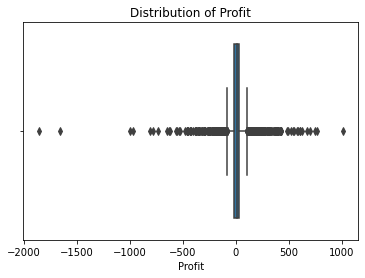

In [323]:
sns.boxplot(a['Profit'])
plt.title("Distribution of Profit")
plt.show()

### There is positive and negative profit

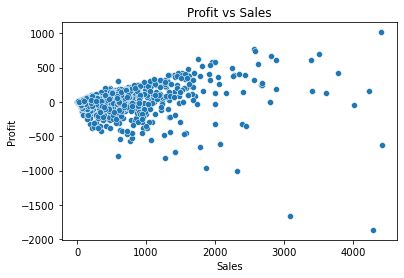

In [324]:
sns.scatterplot(a['Sales'],a['Profit'])
plt.title("Profit vs Sales")
plt.show()


### The increase in profit sees  increase in sales

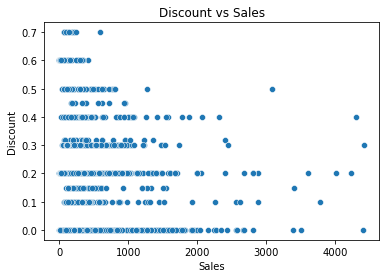

In [325]:
sns.scatterplot(a['Sales'],a['Discount'])
plt.title("Discount vs Sales")
plt.show()

### There is no clear correlation between profit and sales

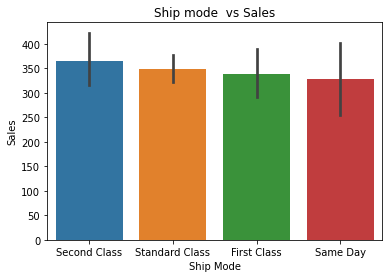

In [326]:
sns.barplot(a['Ship Mode'],a['Sales'])
plt.title("Ship mode  vs Sales")
plt.show()

### All the ship modes have almost the same sales

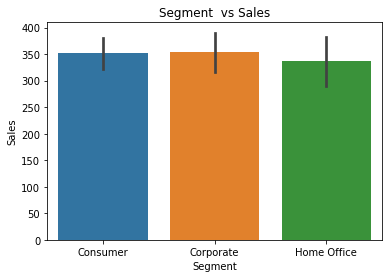

In [327]:
sns.barplot(a['Segment'],a['Sales'])
plt.title("Segment  vs Sales")
plt.show()

### All segments contribute equally to the sales

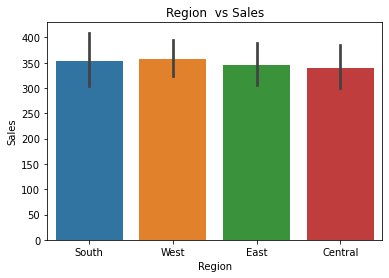

In [328]:
sns.barplot(a['Region'],a['Sales'])
plt.title("Region  vs Sales")
plt.show()

### All regions have almost the same sales

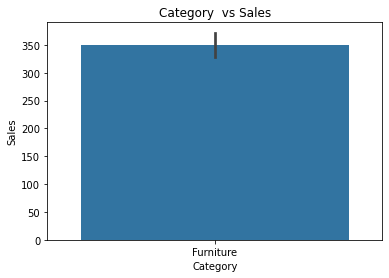

In [329]:
sns.barplot(a['Category'],a['Sales'])
plt.title("Category  vs Sales")
plt.show()

### Technology category has the most contribution for the sales in the categories. Office supplies contributes the least

## Here we resample the data into monthly data

In [330]:
data=a.resample('M').sum()

In [331]:
data

,Sales,Quantity,Discount,Profit,Ship Mode encode,Segment encode,City encode,State encode,Region encode,Category encode,Sub-Category encode
Order Date,,,,,,,,,,,
2014-01-31,6242.5250,70,2.70,805.4665,42,9,4287,400,34,0,28
2014-02-28,1839.6580,23,0.80,120.6917,14,3,959,170,8,0,13
2014-03-31,14573.9560,131,7.60,-1128.6550,81,25,6538,801,55,0,56
2014-04-30,7944.8370,81,3.45,554.3801,66,26,5134,505,49,0,50
2014-05-31,6912.7870,97,6.15,-349.8776,54,9,4354,505,30,0,39
2014-06-30,13206.1256,122,4.72,596.3153,78,12,6293,813,45,0,54
2014-07-31,10821.0510,114,6.15,374.2467,80,24,6850,612,65,0,55
2014-08-31,7320.3465,107,3.15,663.4717,55,10,5079,396,48,0,44
2014-09-30,23816.4808,208,8.67,1858.5976,118,37,12532,1470,74,0,95


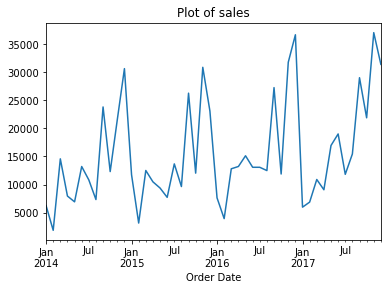

In [332]:
data.Sales.plot()
plt.title("Plot of sales")
plt.show()

# Characteristics of Time series

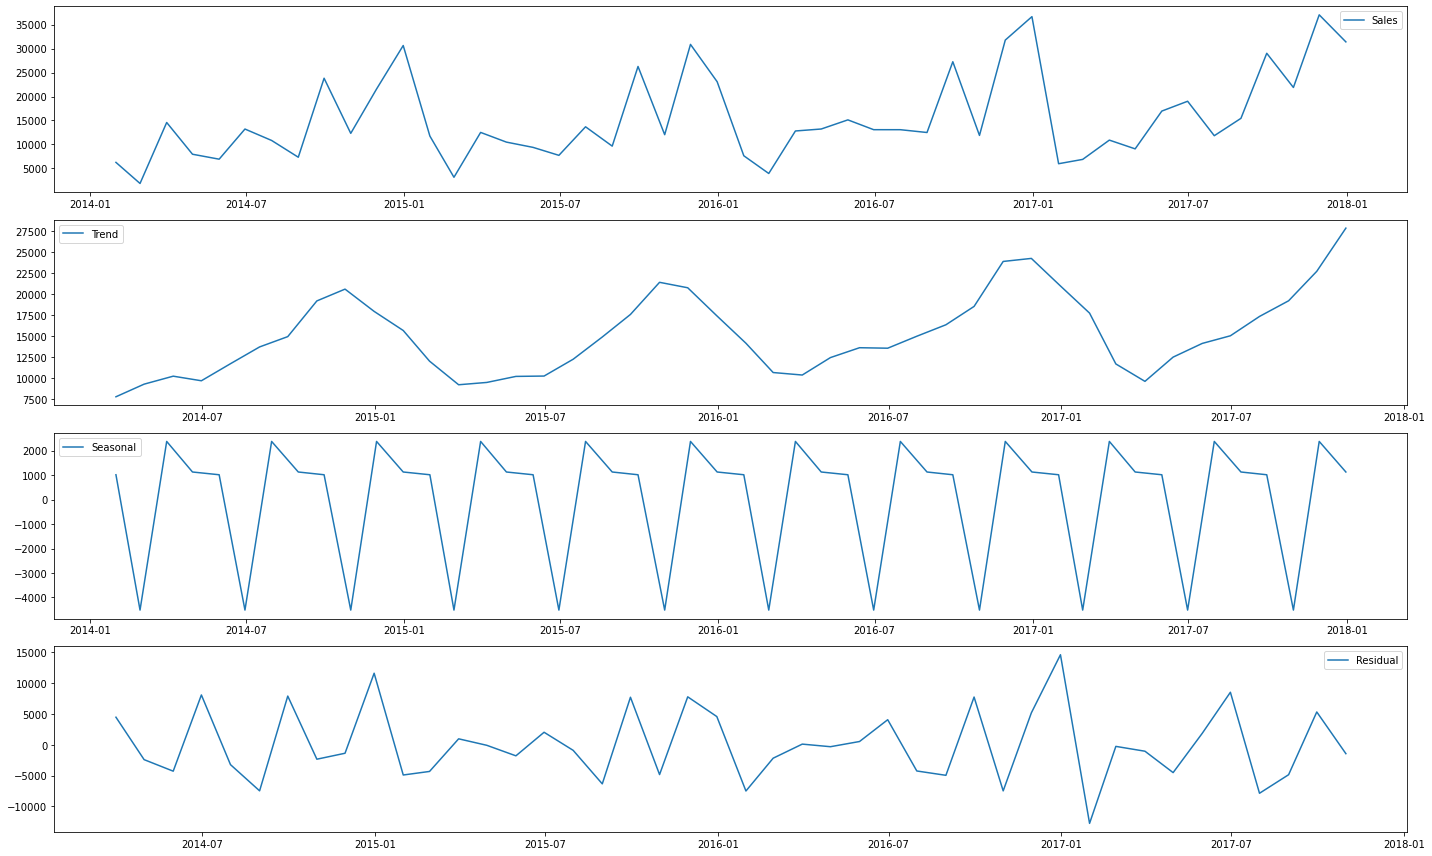

In [333]:
# different components of the Time series data
# period = 4 since the data is quaterly

decomposition=seasonal_decompose(data.Sales, period=4)
d_trend=decomposition.trend
d_seasonal=decomposition.seasonal
d_residual=decomposition.resid

# plotting all the 4 graphs
fig,ax = plt.subplots(4,1,figsize=(20,12))

plt.subplot(411)
plt.plot(data.Sales,label='Sales')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(d_trend,label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(d_seasonal,label='Seasonal')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(d_residual,label='Residual')
plt.legend(loc='best')

plt.tight_layout()

### We can observe from the graphs above that the data has a trend and is seasonal

# Check for Stationarity

In [334]:
# ADF test to determine data stationarity
def checkStationarity(data):
    pvalue = adfuller(data)[1]

    if pvalue < 0.05:
        msg = "pvalue={}. Data is Stationary. Proceed to model building".format(pvalue)
    else:
        msg = "pvalue={}. Data is not Stationary. Make the data stationary before model building".format(pvalue)

    return msg

In [335]:
checkStationarity(data.Sales)

'pvalue=8.450793985809654e-05. Data is Stationary. Proceed to model building'

### We use the Augmented Dicky Fuller test to test for stationarity  
### The given data is  stationary. So we can proceed forward

# Smoothen the data

## Here we use Triple exponential smoothing as the data has level, trend and seasonality

In [336]:
# build model
model = ExponentialSmoothing(data.Sales,trend='add',seasonal='add',seasonal_periods=12).fit()

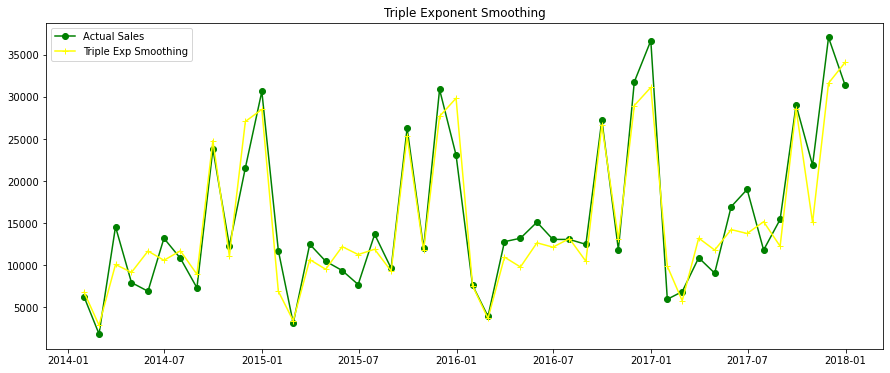

In [337]:
# plot the actual and triple smoothing values
plt.figure(figsize=(15,6))
plt.plot(data.Sales, marker='o',color='green',label='Actual Sales')
plt.plot(model.fittedvalues,marker='+',color='yellow',label='Triple Exp Smoothing')
plt.legend()
plt.title('Triple Exponent Smoothing')
plt.show()

In [338]:
smooth_values=model.fittedvalues

# Plot ACF and PACF

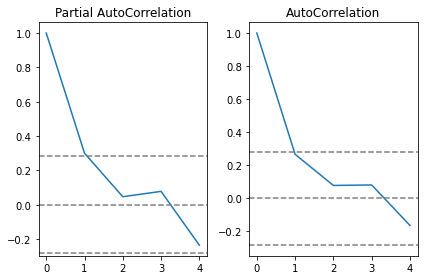

In [339]:
# p -> PACF (partial autocorrelation graph)
# q -> ACF (auto correlation graph)
# d -> differential level (from top)

# since, lags cannot be determined at the beginning, set a random number initially
lag_acf = acf(smooth_values, nlags=4)
lag_pacf = pacf(smooth_values, nlags=4, method='ols')

# plot PACF (p)
plt.subplot(121)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color="gray")
plt.axhline(y=-1.96/np.sqrt(len(data)),linestyle='--',color="gray")
plt.axhline(y=1.96/np.sqrt(len(data)),linestyle='--',color="gray")
plt.title("Partial AutoCorrelation")

# plot ACF (q)
plt.subplot(122)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color="gray")
plt.axhline(y=-1.96/np.sqrt(len(data)),linestyle='--',color="gray")
plt.axhline(y=1.96/np.sqrt(len(data)),linestyle='--',color="gray")
plt.title("AutoCorrelation")

plt.tight_layout()

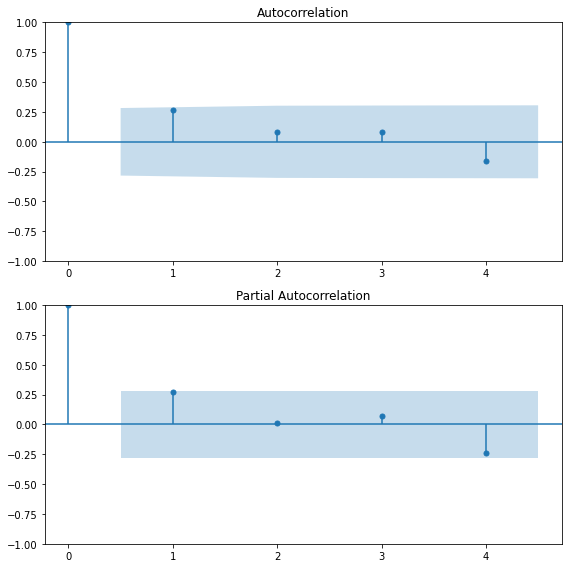

In [340]:
fig=plt.figure(figsize=(8,8))
ax1=fig.add_subplot(211)
sm.graphics.tsa.plot_acf(smooth_values,lags=4,ax=ax1)
ax2=fig.add_subplot(212)
sm.graphics.tsa.plot_pacf(smooth_values,lags=4,ax=ax2)
plt.tight_layout()

## Fromt the above graphs we can observe that the good value of p from Autocorrelation is 2 and value of q from Partial autocorrelation is also 2

# Use auto ARIMA for selection of p, d, q

In [341]:
# auto ARIMA (to help in the selection of p,d,q)
m1 = auto_arima(smooth_values,start_p=0,max_p=3, start_q=0,max_q=3, seasonal=False, trace=True)
print(m1.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1074.445, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1021.193, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1056.461, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1017.156, Time=0.23 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=1015.958, Time=0.09 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=1015.256, Time=0.11 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1013.352, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1013.748, Time=0.05 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.20 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1014.573, Time=0.08 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1010.089, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1008.144, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1006.596, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1

### From auto arima the is Best model:  ARIMA(1,0,0)(0,0,0)[0] based on the least AIC value

# TASK 4

# Build the ARIMA model

In [418]:
# start with initial values for p and q based on auto_arima recommendation
p=1; d=0; q=0
m1 = ARIMA(smooth_values,order=(p,d,q)).fit()
print(m1.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   48
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -500.079
Date:                Fri, 25 Nov 2022   AIC                           1006.158
Time:                        11:48:59   BIC                           1011.771
Sample:                    01-31-2014   HQIC                          1008.279
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.498e+04   1713.125      8.745      0.000    1.16e+04    1.83e+04
ar.L1          0.2979      0.134      2.221      0.026       0.035       0.561
sigma2      6.554e+07      0.117   5.61e+08      0.0

# Predict the test data using the model

In [419]:
# predictions
predictions = m1.predict()
print(predictions)

Order Date
2014-01-31    14980.791605
2014-02-28    12540.918175
2014-03-31    11376.203585
2014-04-30    13524.348253
2014-05-31    13245.872818
2014-06-30    13999.755792
2014-07-31    13673.123085
2014-08-31    14007.795900
2014-09-30    13177.501795
2014-10-31    17906.315471
2014-11-30    13820.238579
2014-12-31    18584.056876
2015-01-31    19012.179519
2015-02-28    12577.322252
2015-03-31    11532.551512
2015-04-30    13698.261305
2015-05-31    13355.163076
2015-06-30    14156.940893
2015-07-31    13876.657110
2015-08-31    14063.895779
2015-09-30    13290.192025
2015-10-31    18062.594428
2015-11-30    14023.271565
2015-12-31    18766.731092
2016-01-31    19407.708178
2016-02-29    12773.625965
2016-03-31    11613.981047
2016-04-30    13785.320471
2016-05-31    13436.303804
2016-06-30    14291.655040
2016-07-31    14137.874385
2016-08-31    14441.105768
2016-09-30    13636.735069
2016-10-31    18461.551222
2016-11-30    14428.203909
2016-12-31    19148.909343
2017-01-31    197

In [420]:
forecast=pd.DataFrame(m1.forecast(4))  #the forecast values for the future 16 quaters which is next 4 years
forecast

,predicted_mean
2018-01-31,20672.408443
2018-02-28,16676.290232
2018-03-31,15485.870509
2018-04-30,15131.251591


In [421]:
data['predicted_values']=predictions

In [422]:
data

,Sales,Quantity,Discount,Profit,Ship Mode encode,Segment encode,City encode,State encode,Region encode,Category encode,Sub-Category encode,predicted_values,smooth_values,error,predicted_values_SARIMA
Order Date,,,,,,,,,,,,,,,
2014-01-31,6242.5250,70,2.70,805.4665,42,9,4287,400,34,0,28,14980.791605,6790.384086,-8190.407519,0.000000
2014-02-28,1839.6580,23,0.80,120.6917,14,3,959,170,8,0,13,12540.918175,2880.555398,-9660.362776,6730.268414
2014-03-31,14573.9560,131,7.60,-1128.6550,81,25,6538,801,55,0,56,11376.203585,10091.659067,-1284.544518,3200.810696
2014-04-30,7944.8370,81,3.45,554.3801,66,26,5134,505,49,0,50,13524.348253,9156.845289,-4367.502964,9697.258587
2014-05-31,6912.7870,97,6.15,-349.8776,54,9,4354,505,30,0,39,13245.872818,11687.553932,-1558.318886,8840.522791
2014-06-30,13206.1256,122,4.72,596.3153,78,12,6293,813,45,0,54,13999.755792,10591.081079,-3408.674713,11020.393619
2014-07-31,10821.0510,114,6.15,374.2467,80,24,6850,612,65,0,55,13673.123085,11714.543758,-1958.579327,10004.511000
2014-08-31,7320.3465,107,3.15,663.4717,55,10,5079,396,48,0,44,14007.795900,8927.330702,-5080.465198,10855.847622
2014-09-30,23816.4808,208,8.67,1858.5976,118,37,12532,1470,74,0,95,13177.501795,24801.478354,11623.976559,8474.764803


In [423]:
data['smooth_values']=smooth_values

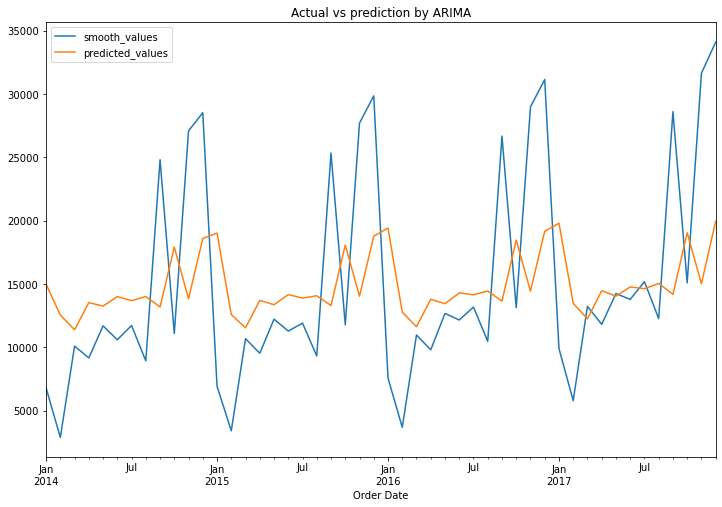

In [424]:
data[['smooth_values','predicted_values']].plot(figsize=(12,8))    #graph for actual vs predicted sales
plt.title("Actual vs prediction by ARIMA")
plt.show()

In [425]:
mse_ARIMA = mean_squared_error(smooth_values,predictions,squared=False)       #root mean square error
print('RMSE: ' ,mse_ARIMA) 

RMSE:  8097.825649446321


In [388]:
data['error']=data.smooth_values-data.predicted_values

In [389]:
data

,Sales,Quantity,Discount,Profit,Ship Mode encode,Segment encode,City encode,State encode,Region encode,Category encode,Sub-Category encode,predicted_values,smooth_values,error,predicted_values_SARIMA
Order Date,,,,,,,,,,,,,,,
2014-01-31,6242.5250,70,2.70,805.4665,42,9,4287,400,34,0,28,14980.791605,6790.384086,-8190.407519,0.000000
2014-02-28,1839.6580,23,0.80,120.6917,14,3,959,170,8,0,13,12540.918175,2880.555398,-9660.362776,6730.268414
2014-03-31,14573.9560,131,7.60,-1128.6550,81,25,6538,801,55,0,56,11376.203585,10091.659067,-1284.544518,3200.810696
2014-04-30,7944.8370,81,3.45,554.3801,66,26,5134,505,49,0,50,13524.348253,9156.845289,-4367.502964,9697.258587
2014-05-31,6912.7870,97,6.15,-349.8776,54,9,4354,505,30,0,39,13245.872818,11687.553932,-1558.318886,8840.522791
2014-06-30,13206.1256,122,4.72,596.3153,78,12,6293,813,45,0,54,13999.755792,10591.081079,-3408.674713,11020.393619
2014-07-31,10821.0510,114,6.15,374.2467,80,24,6850,612,65,0,55,13673.123085,11714.543758,-1958.579327,10004.511000
2014-08-31,7320.3465,107,3.15,663.4717,55,10,5079,396,48,0,44,14007.795900,8927.330702,-5080.465198,10855.847622
2014-09-30,23816.4808,208,8.67,1858.5976,118,37,12532,1470,74,0,95,13177.501795,24801.478354,11623.976559,8474.764803


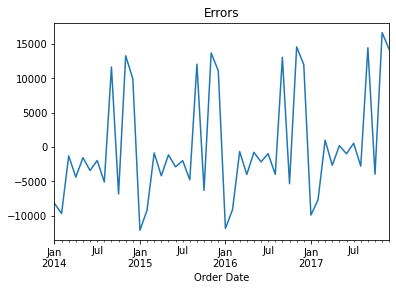

In [390]:
data.error.plot()
plt.title("Errors")
plt.show()

In [391]:
f=m1.predict(start=len(data)-2,end=len(data)+10,typ='levels')

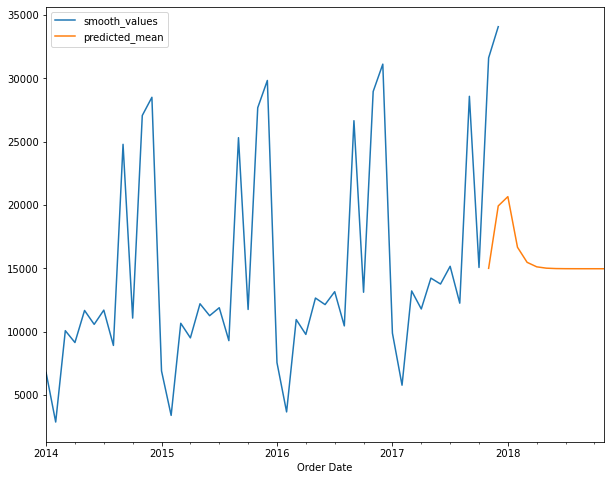

In [392]:
data['smooth_values'].plot(figsize=(10,8),legend=True)
f.plot(legend=True)
plt.show()

### We can see from the graph that the ARIMA model does not predict the future values of sales properly. There is a flat line for the future sales indication of wrong preiciton.
### So ARIMA is not the correct model for prediciton of sales

# SARIMA

### Build the SARIMA model

In [433]:
# for seasonal data, use the SARIMAX. start with initial values for p,d,q
p=1; q=0; d=0
m1 = sm.tsa.statespace.SARIMAX(data['smooth_values'],order=(p,d,q),seasonal_order=(p,d,q,12)).fit()

### Use the model to predict the value

In [434]:
# predict
predictions = m1.predict()

### Collate actual, predicted and errors together

In [435]:
data['predicted_values_SARIMA']=predictions

In [436]:
data

,Sales,Quantity,Discount,Profit,Ship Mode encode,Segment encode,City encode,State encode,Region encode,Category encode,Sub-Category encode,predicted_values,smooth_values,error,predicted_values_SARIMA
Order Date,,,,,,,,,,,,,,,
2014-01-31,6242.5250,70,2.70,805.4665,42,9,4287,400,34,0,28,14980.791605,6790.384086,-8190.407519,0.000000
2014-02-28,1839.6580,23,0.80,120.6917,14,3,959,170,8,0,13,12540.918175,2880.555398,-9660.362776,6730.268414
2014-03-31,14573.9560,131,7.60,-1128.6550,81,25,6538,801,55,0,56,11376.203585,10091.659067,-1284.544518,3200.810696
2014-04-30,7944.8370,81,3.45,554.3801,66,26,5134,505,49,0,50,13524.348253,9156.845289,-4367.502964,9697.258587
2014-05-31,6912.7870,97,6.15,-349.8776,54,9,4354,505,30,0,39,13245.872818,11687.553932,-1558.318886,8840.522791
2014-06-30,13206.1256,122,4.72,596.3153,78,12,6293,813,45,0,54,13999.755792,10591.081079,-3408.674713,11020.393619
2014-07-31,10821.0510,114,6.15,374.2467,80,24,6850,612,65,0,55,13673.123085,11714.543758,-1958.579327,10004.511000
2014-08-31,7320.3465,107,3.15,663.4717,55,10,5079,396,48,0,44,14007.795900,8927.330702,-5080.465198,10855.847622
2014-09-30,23816.4808,208,8.67,1858.5976,118,37,12532,1470,74,0,95,13177.501795,24801.478354,11623.976559,8474.764803


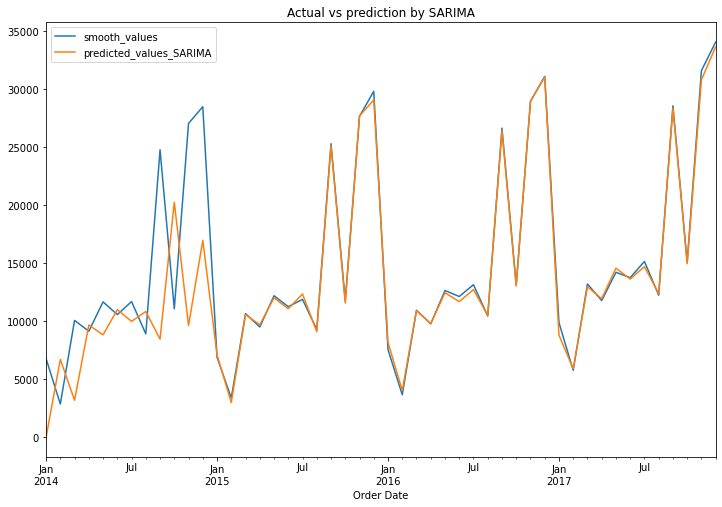

In [437]:
data[['smooth_values','predicted_values_SARIMA']].plot(figsize=(12,8))    #graph for actual vs predicted sales
plt.title("Actual vs prediction by SARIMA")
plt.show()

### Forecast the future values using the model

In [438]:
fcast = m1.predict(start=len(data)-1, end=len(data)+11, typ='levels').rename('Forecast')

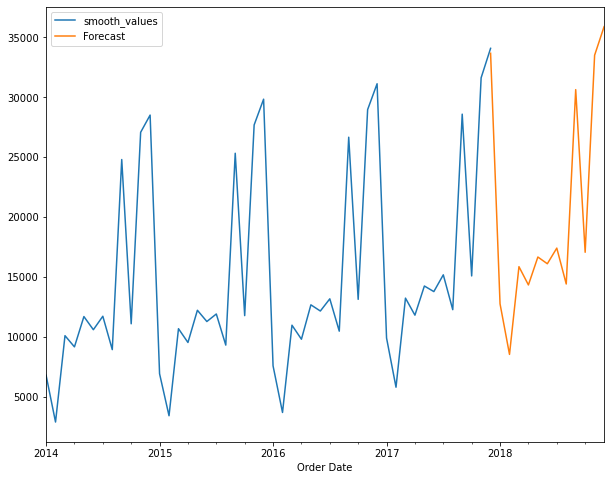

In [439]:
data['smooth_values'].plot(figsize=(10,8),legend=True)
fcast.plot(legend=True)
plt.show()

### From the above graph we can see that the forecast of the sales is correctly done by the SARIMA model

In [440]:
fcast

2017-12-31    33677.432716
2018-01-31    12750.771956
2018-02-28     8528.697829
2018-03-31    15855.315703
2018-04-30    14328.819390
2018-05-31    16660.976438
2018-06-30    16099.024903
2018-07-31    17405.291161
2018-08-31    14407.903391
2018-09-30    30639.829794
2018-10-31    17056.743773
2018-11-30    33513.297199
2018-12-31    35895.773399
Freq: M, Name: Forecast, dtype: float64

In [441]:
mse_SARIMA = mean_squared_error(smooth_values,predictions,squared=False)       #root mean square error
print('RMSE: ',mse_SARIMA) 

RMSE:  4367.802167813433


# SARIMAX

In [398]:
a.corr()

,Sales,Quantity,Discount,Profit,Ship Mode encode,Segment encode,City encode,State encode,Region encode,Category encode,Sub-Category encode
Sales,1.000000,0.437464,-0.028576,0.173510,0.007707,-0.007935,0.003902,0.044913,0.013003,NaN,-0.094981
Quantity,0.437464,1.000000,-0.015695,0.061213,0.007826,0.012078,-0.000333,0.014495,0.012202,NaN,0.000703
Discount,-0.028576,-0.015695,1.000000,-0.483769,-0.019552,-0.021895,-0.202931,0.108197,-0.304835,NaN,0.039751
Profit,0.173510,0.061213,-0.483769,1.000000,-0.002213,0.015690,0.051947,-0.007357,0.064321,NaN,-0.123743
Ship Mode encode,0.007707,0.007826,-0.019552,-0.002213,1.000000,-0.011243,0.004147,-0.003438,-0.023981,NaN,0.027728
Segment encode,-0.007935,0.012078,-0.021895,0.015690,-0.011243,1.000000,0.003561,0.022319,-0.011290,NaN,0.038364
City encode,0.003902,-0.000333,-0.202931,0.051947,0.004147,0.003561,1.000000,0.052705,0.256363,NaN,-0.004701
State encode,0.044913,0.014495,0.108197,-0.007357,-0.003438,0.022319,0.052705,1.000000,-0.462005,NaN,0.004480
Region encode,0.013003,0.012202,-0.304835,0.064321,-0.023981,-0.011290,0.256363,-0.462005,1.000000,NaN,0.017184
Category encode,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Based on the correlation values with the sales we select the quantity and Profit as the exogenous features

In [399]:
b=data[['smooth_values','Quantity','Profit']]

In [400]:
b

,smooth_values,Quantity,Profit
Order Date,,,
2014-01-31,6790.384086,70,805.4665
2014-02-28,2880.555398,23,120.6917
2014-03-31,10091.659067,131,-1128.6550
2014-04-30,9156.845289,81,554.3801
2014-05-31,11687.553932,97,-349.8776
2014-06-30,10591.081079,122,596.3153
2014-07-31,11714.543758,114,374.2467
2014-08-31,8927.330702,107,663.4717
2014-09-30,24801.478354,208,1858.5976


In [401]:
s=int(0.8*len(b))

In [402]:
train_df = b.iloc[:s] 
test_df = b.iloc[s:] 

In [403]:
# build model 
model = SARIMAX(train_df.smooth_values, order=(0,1,1), seasonal_order=(0,1,1,12)).fit()

In [404]:
forecast = model.forecast(len(test_df)) 
forecast

2017-03-31    13084.888540
2017-04-30    11913.419835
2017-05-31    14802.869011
2017-06-30    14331.058543
2017-07-31    15397.619066
2017-08-31    12683.332569
2017-09-30    28899.543529
2017-10-31    15358.136126
2017-11-30    31199.766304
2017-12-31    33350.150863
Freq: M, Name: predicted_mean, dtype: float64

RMSE: 422.3874176183464


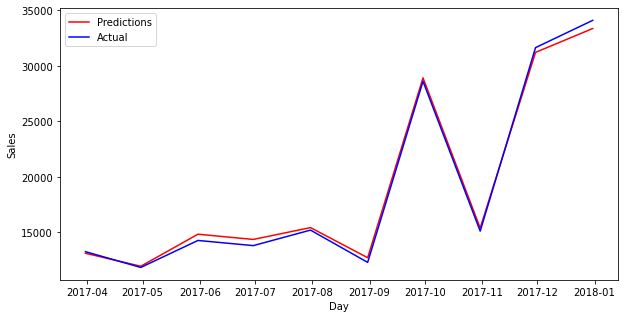

In [405]:
plt.figure(figsize=(10,5)) 
plt.plot(forecast, 'r', label = 'Predictions') 
plt.plot(test_df.smooth_values, 'b', label='Actual') 
plt.xlabel('Day') 
plt.ylabel('Sales') 
plt.legend() 
mse1 =mean_squared_error(test_df.smooth_values,forecast) 
print('RMSE: ' + str(np.sqrt(mse1) ))

In [406]:
exog_train = train_df[['Quantity','Profit']] 
exog_test =test_df[['Quantity','Profit']]
print(exog_train.head(5))
print(exog_test.head(5))


            Quantity     Profit
Order Date                     
2014-01-31        70   805.4665
2014-02-28        23   120.6917
2014-03-31       131 -1128.6550
2014-04-30        81   554.3801
2014-05-31        97  -349.8776
            Quantity     Profit
Order Date                     
2017-03-31       123  1000.8532
2017-04-30       175   202.4624
2017-05-31       184   -72.8829
2017-06-30       176   904.9956
2017-07-31       183   324.6244


In [407]:
model = SARIMAX(train_df.smooth_values, order=(0,1,1), seasonal_order=(0,1,1,12), exog = exog_train.values).fit()

In [408]:
forecast = model.forecast(len(test_df), exog=exog_test.values) 
forecast

2017-03-31    13329.689911
2017-04-30    11791.209856
2017-05-31    14785.082444
2017-06-30    14113.296831
2017-07-31    15250.310711
2017-08-31    12625.960080
2017-09-30    28843.428664
2017-10-31    15011.543079
2017-11-30    30958.217931
2017-12-31    33101.074389
Freq: M, Name: predicted_mean, dtype: float64

RMSE: 452.66590325456554


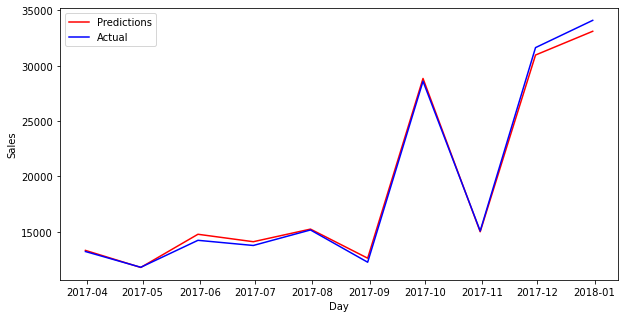

In [409]:
plt.figure(figsize=(10,5)) 
plt.plot(forecast, 'r', label = 'Predictions') 
plt.plot(test_df.smooth_values, 'b', label='Actual') 
plt.xlabel('Day') 
plt.ylabel('Sales')
plt.legend() 
mse1 = mean_squared_error(test_df.smooth_values,forecast) 
print('RMSE: ' + str(np.sqrt(mse1) ))

In [446]:
fcast = m1.predict(start=len(data)-1, end=len(data)+11, typ='levels').rename('Forecast')

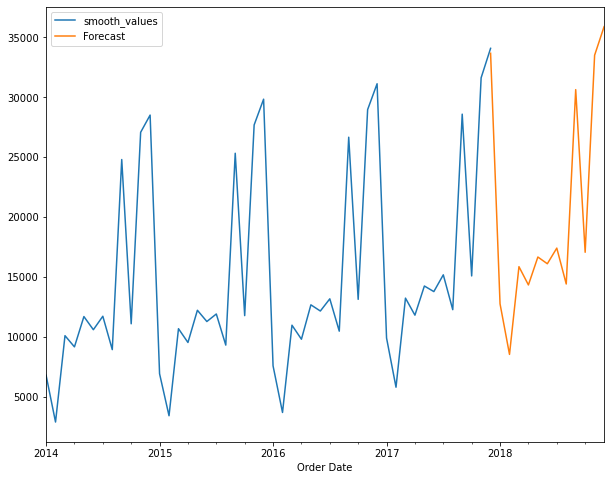

In [447]:
data['smooth_values'].plot(figsize=(10,8),legend=True)
fcast.plot(legend=True)
plt.show()

### From the above graph we can see that the forecast of the sales is correctly done by the SARIMAX model

In [415]:
mse_SARIMAX =mean_squared_error(test_df.smooth_values,forecast,squared=False) 
print('RMSE: ',mse_SARIMAX) 

RMSE:  452.66590325456554


# Model selection

In [442]:
error={mse_ARIMA:'ARIMA',mse_SARIMA:"SARIMA",mse_SARIMAX:"SARIMAX"}

In [443]:
name=list(error.keys())
values=list(error.values())

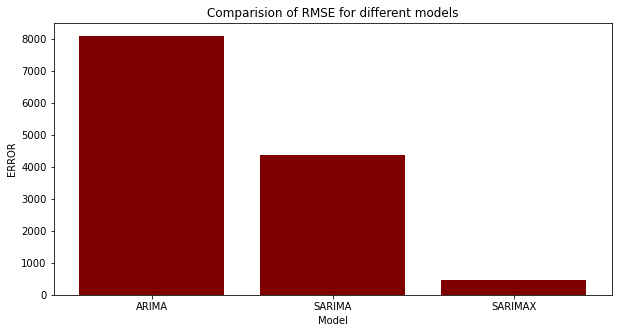

In [448]:
plt.figure(figsize=(10,5))
plt.bar(values,name,color='maroon')
plt.title("Comparision of RMSE for different models")
plt.xlabel("Model")
plt.ylabel("ERROR")
plt.show()

### Based on the RMSE values of the model we can see that the SARIMAX model gives the best results

### So the SARIMAX model is the best model

# BEST MODEL : SARIMAX

In [449]:
# build model 
model = SARIMAX(train_df.smooth_values, order=(0,1,1), seasonal_order=(0,1,1,12)).fit()

In [450]:
forecast = model.forecast(len(test_df)) 
forecast

2017-03-31    13084.888540
2017-04-30    11913.419835
2017-05-31    14802.869011
2017-06-30    14331.058543
2017-07-31    15397.619066
2017-08-31    12683.332569
2017-09-30    28899.543529
2017-10-31    15358.136126
2017-11-30    31199.766304
2017-12-31    33350.150863
Freq: M, Name: predicted_mean, dtype: float64

RMSE: 422.3874176183464


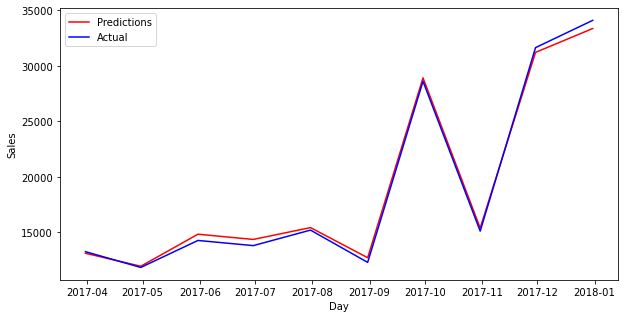

In [451]:
plt.figure(figsize=(10,5)) 
plt.plot(forecast, 'r', label = 'Predictions') 
plt.plot(test_df.smooth_values, 'b', label='Actual') 
plt.xlabel('Day') 
plt.ylabel('Sales') 
plt.legend() 
mse1 =mean_squared_error(test_df.smooth_values,forecast) 
print('RMSE: ' + str(np.sqrt(mse1) ))

In [452]:
exog_train = train_df[['Quantity','Profit']] 
exog_test =test_df[['Quantity','Profit']]
print(exog_train.head(5))
print(exog_test.head(5))


            Quantity     Profit
Order Date                     
2014-01-31        70   805.4665
2014-02-28        23   120.6917
2014-03-31       131 -1128.6550
2014-04-30        81   554.3801
2014-05-31        97  -349.8776
            Quantity     Profit
Order Date                     
2017-03-31       123  1000.8532
2017-04-30       175   202.4624
2017-05-31       184   -72.8829
2017-06-30       176   904.9956
2017-07-31       183   324.6244


In [453]:
model = SARIMAX(train_df.smooth_values, order=(0,1,1), seasonal_order=(0,1,1,12), exog = exog_train.values).fit()

In [454]:
forecast = model.forecast(len(test_df), exog=exog_test.values) 
forecast

2017-03-31    13329.689911
2017-04-30    11791.209856
2017-05-31    14785.082444
2017-06-30    14113.296831
2017-07-31    15250.310711
2017-08-31    12625.960080
2017-09-30    28843.428664
2017-10-31    15011.543079
2017-11-30    30958.217931
2017-12-31    33101.074389
Freq: M, Name: predicted_mean, dtype: float64

RMSE: 452.66590325456554


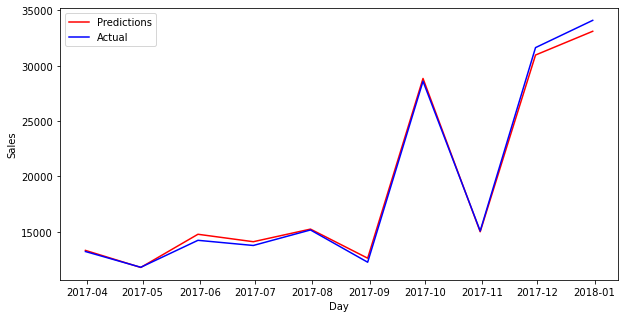

In [455]:
plt.figure(figsize=(10,5)) 
plt.plot(forecast, 'r', label = 'Predictions') 
plt.plot(test_df.smooth_values, 'b', label='Actual') 
plt.xlabel('Day') 
plt.ylabel('Sales')
plt.legend() 
mse1 = mean_squared_error(test_df.smooth_values,forecast) 
print('RMSE: ' + str(np.sqrt(mse1) ))

In [456]:
fcast = m1.predict(start=len(data)-1, end=len(data)+11, typ='levels').rename('Forecast')

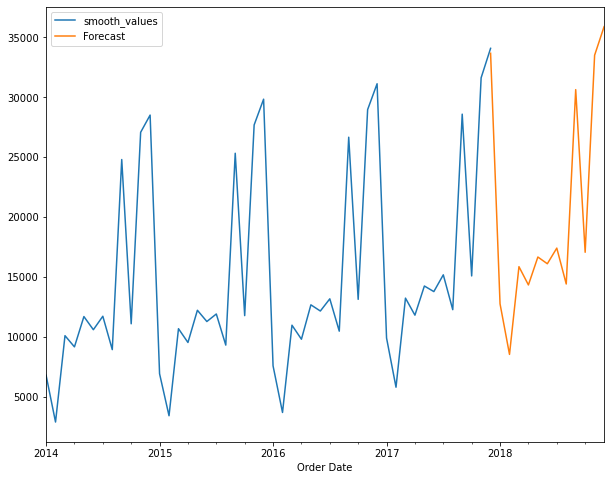

In [457]:
data['smooth_values'].plot(figsize=(10,8),legend=True)
fcast.plot(legend=True)
plt.show()

### From the above graph we can see that the forecast of the sales is correctly done by the SARIMAX model

In [458]:
mse_SARIMAX =mean_squared_error(test_df.smooth_values,forecast,squared=False) 
print('RMSE: ',mse_SARIMAX) 

RMSE:  452.66590325456554


### The error in SARIMAX model is 452.66 which is very low.

### From the prediction graph we can observe that the real and predicted values are almost same

### The forecast aslo shows the same trend and seasonality which approves the model

### The exogemous features we consider are Quantity and Profit

### Hence, we can use the SARIMAX model for future prediction of sales

### Insights

The range of sales lies between 0 to 500  
The discount ranges from 0 - 0.3 for furniture  
There is positive and negative profit  
The increase in profit sees increase in sales  
There is no clear correlation between profit and sales  
All the ship modes have almost the same sales  
All segments contribute equally to the sales  
Technology category has the most contribution for the sales in the categories. Office supplies contributes the least  